# Convolutional Neural Networks

In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T

from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, batch_stream, onehot, Net

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
y = onehot(y)

In [7]:
class CNN(Net):
    def __init__(self):
        X_batch = T.ftensor4('X_batch')
        y_batch = T.fmatrix('y_batch')
        
        input_l = layers.InputLayer(shape=(None, ) + X.shape[1:], input_var=X_batch)
        
        conv1 = layers.Conv2DLayer(
            input_l,
            num_filters=16,
            filter_size=(5, 5),
            pad='same',
            nonlinearity=nonlinearities.softplus
        )
        
        pool1 = layers.Pool2DLayer(
            conv1,
            pool_size=(2, 2)
        )
        
        conv2 = layers.Conv2DLayer(
            pool1,
            num_filters=32,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.softplus
        )
        
        pool2 = layers.Pool2DLayer(
            conv2,
            pool_size=(2, 2)
        )
        
        conv3 = layers.Conv2DLayer(
            pool2,
            num_filters=64,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.softplus
        )
        
        pool3 = layers.Pool2DLayer(
            conv3,
            pool_size=(2, 2)
        )
        
        conv3 = layers.Conv2DLayer(
            pool3,
            num_filters=128,
            filter_size=(2, 2),
            nonlinearity=nonlinearities.softplus
        )
        
        out = layers.DenseLayer(
            conv3,
            num_units=10,
            nonlinearity=nonlinearities.softmax
        )
        
        self.net = out
        
        prediction = layers.get_output(out)
        
        reg = regularization.regularize_network_params(
            out,
            regularization.l1
        )

        log_loss = T.mean(objectives.categorical_crossentropy(prediction, y_batch))
        
        c_regularization = T.fscalar('C_regularization')
        
        loss = log_loss + c_regularization * reg
        
        learning_rate = T.fscalar('learning rate')
        upd = updates.adadelta(loss, layers.get_all_params(out), learning_rate=learning_rate)
        
        self.train = theano.function(
            [X_batch, y_batch, c_regularization, learning_rate],
            log_loss,
            updates=upd
        )

        self.predict = theano.function([X_batch], prediction)
        

    def fit(self, X, y, c_reg = 1.0e-3, learning_rate=1.0, n_epoches=1, batch_size=32, watcher=None):
        history = np.zeros(shape=(n_epoches, X.shape[0] / batch_size))
        
        for epoch in xrange(n_epoches):
            for i, (X_batch, y_batch) in enumerate(batch_stream([X, y], batch_size=batch_size)):
                history[epoch, i] = self.train(X_batch, y_batch, c_reg, learning_rate)
            
            if watcher is not None:
                watcher.draw(history[:(epoch + 1)])

In [8]:
cnn = CNN()

/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [9]:
print cnn

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 16, 28, 28)
  number of params: 800
  output shape:(None, 16, 14, 14)
  number of params: 0.0
  output shape:(None, 32, 12, 12)
  number of params: 9216
  output shape:(None, 32, 6, 6)
  number of params: 0.0
  output shape:(None, 64, 4, 4)
  number of params: 36864
  output shape:(None, 64, 2, 2)
  number of params: 0.0
  output shape:(None, 128, 1, 1)
  number of params: 65536
  output shape:(None, 10)
  number of params: 2560


<IPython.core.display.Javascript object>


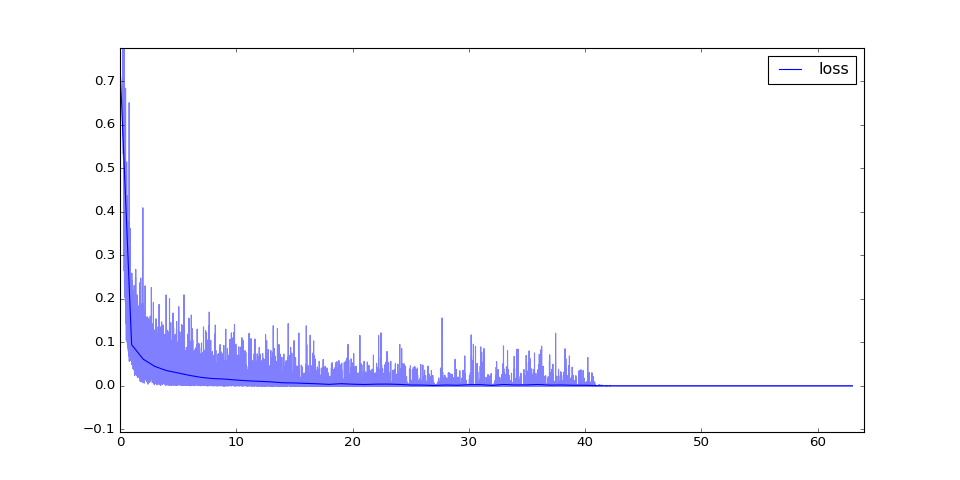

In [10]:
watcher = NNWatcher()

In [11]:
cnn.fit(X, y, c_reg = 1.0e-6, learning_rate=1.0, n_epoches=64, batch_size=128, watcher=watcher)

In [12]:
predicted = np.argmax(cnn.predict(X_test), axis=1)

In [13]:
np.mean(predicted == y_test)

0.99260000000000004

In [14]:
W1 = [param.get_value() for param in layers.get_all_params(cnn.net)][0]

In [15]:
W1.shape

(16, 1, 5, 5)

In [17]:
W1 = W1.reshape(-1, 5, 5)

<IPython.core.display.Javascript object>


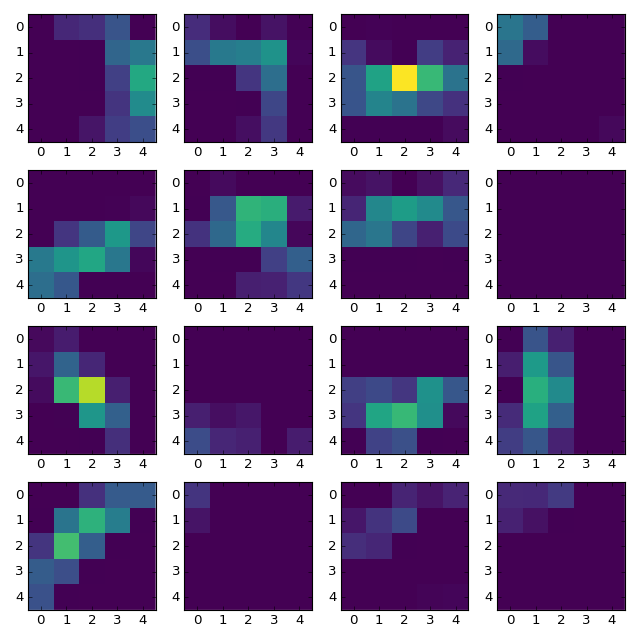

In [19]:
import itertools

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2 , nrows * 2))

for i, j in itertools.product(range(nrows), range(ncols)):
    k = i * ncols + j
    
    vmin = np.min(np.abs(W1))
    vmax = np.max(np.abs(W1))
    
    ax[i, j].imshow(
        W1[k],
        interpolation='None', cmap=plt.cm.viridis, vmin=vmin, vmax=vmax
    )

#fig.suptitle('Visualization of the first hidden coefficients')
fig.tight_layout()
plt.show()